# Определение перспективного тарифа для телеком-компании

## Описание задачи

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: **«Смарт»** и **«Ультра»**. Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, **какой тариф приносит больше денег**.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и определить, какой тариф приносит больше денег.

тариф | **Смарт** | **Ультра**
---:| :--- | :---
Плата в месяц | 550₽ | 1950₽
**Включено** |---|---
связь | 500 мин | 3000 мин
смс | 50 | 1000
интернет | 15 Гб | 30 Гб
**Стоимость услуг сверх тарифного пакета**|---|---
связь | 3₽ за минуту | 1₽ за минуту
смс | 3₽ | 1₽
1 Гб | 200₽ | 150₽

Секунды в рамках каждого звонка округляются до минут.<br>
Суммараный веб-трафик за месяц округляется до гигабайтов.<br>
1 гигабайт = 1024 мегабайта

- Опишите поведение клиентов оператора, исходя из выборки:
    - Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
    - Посчитайте среднее количество, дисперсию и стандартное отклонение.
    - Постройте гистограммы. Опишите распределения.
- Проверьте гипотезы:
    - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
    - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Пороговое значение alpha задайте самостоятельно.
- Поясните:
    - как вы формулировали нулевую и альтернативную гипотезы;
    - какой критерий использовали для проверки гипотез и почему.
- Напишите общий вывод

## Описание данных


**Таблица users** (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tarif` — название тарифного плана`
----

**Таблица calls** (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок
----

**Таблица messages** (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение
----

**Таблица internet** (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя
----

**Таблица tariffs** (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета

## Предобработка данных

Соберём данные в удобный нам формат, заодно проверим, что с ними всё ок, уберём персональные данные.

За основу возьмём таблицу ползователей. Для каждого посчитаем все интересующие нас параметры.

In [ ]:
import numpy as np
import pandas as pd
import requests
import zipfile

from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from scipy import stats as st

In [2]:
# зададим дефолтные настройки отображения таблиц и графиков
pd.set_option('display.float_format', '{:_.2f}'.format)
#pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 30)
plt.rcParams['font.size'] = '12'
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# наши данные

# CALLS = '/datasets/calls.csv'
# INTERNET = '/datasets/internet.csv'
# MESSAGES = '/datasets/messages.csv'
# USERS = '/datasets/users.csv'

CALLS = 'data/calls.csv'
INTERNET = 'data/internet.csv'
MESSAGES = 'data/messages.csv'
USERS = 'data/users.csv'

In [4]:
# заведём словарик с условиями тарифов
TARIFF = {
'smart': {
    'price': 550,
    
    'limits': {
        'calls': 500,
        'sms': 50, 
        'web': 15},
    
    'fee': {
        'calls': 3,
        'sms': 3,
        'web': 200}},

'ultra': {
   'price': 1950,
   
   'limits': {
        'calls': 3000,
        'sms': 1000,
        'web': 30},
    
   'fee': {
        'calls': 1,
        'sms': 1,
        'web': 150}}
        }

### Абоненты

Посмотрим на наших абонентов.

In [5]:
# загрузим данные: распарсим даты
users_df = pd.read_csv(USERS, parse_dates=[2,6])

In [6]:
# сразу проверим, нет ли дублей
users_df.duplicated().sum()

0

In [7]:
# посмотрим на типы данных, количество пропусков
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Пока всё выглядит ок. Пройдёмся по колонкам – убедимся, что в них всё правдоподобно.

Еще кажется, что не мешало бы добавить пол пользователей – определим его по именам. Для этого из [интернетиков](https://mydata.biz/ru/catalog/databases/names_db) возьмём большой список имён.

После того, как выставим пол, колонки с именами и фамилиями убьём – чем меньше ненужных персональных данных в работе, тем лучше.

In [8]:
# на всякий случай, проверим, есть ли у нас полные тёзки
# нет
users_df.groupby(['first_name', 'last_name'])['user_id'].count().sort_values(ascending=False)

first_name  last_name 
Авксентий   Алексеичев    1
Милица      Меркулова     1
Нателла     Бородина      1
Наталья     Жарова        1
Наида       Боброва       1
            Авраменко     1
Надежда     Чеснокова     1
            Латышева      1
            Аникина       1
Мстислав    Демьянов      1
            Ахматов       1
            Алексеенко    1
Михаил      Крюков        1
            Кравцов       1
Мирослава   Лазарева      1
                         ..
Джемма      Карасева      1
Денис       Алфимов       1
Демьян      Черняев       1
            Логинов       1
Дебора      Асафьева      1
Даниэла     Пугачева      1
            Горбачева     1
Даниил      Алиев         1
            Ёрохов        1
Дана        Новикова      1
            Меркулова     1
            Астапенко     1
Дайна       Березина      1
Григорий    Давыдов       1
Яна         Седова        1
Name: user_id, Length: 500, dtype: int64

In [9]:
# скачаем файл с именами и полом
url = 'https://mydata.biz/storage/download/ebcdfe6fb2d546398010e0d6564a79bb/База%20данных%20имен%20и%20фамилий%20в%20формате%20CSV.zip'
names_file = requests.get(url)
open('names.zip', 'wb').write(names_file.content)
z = zipfile.ZipFile('names.zip')
z.extract('russian_names.csv')

'/Users/noga/Documents/Docs/Моё/Praktikum/5_stat/russian_names.csv'

In [10]:
# загрузим имена и добавим колонку с полом.
names = pd.read_csv('russian_names.csv', sep=';')

male = names[names.Sex == 'М'].Name.values
female = names[names.Sex == 'Ж'].Name.values

def get_sex(name):
    if name in male and name in female:
        return 'mf'
    elif name in female:
        return 'f'
    elif name in male:
        return 'm'
    else:
        return '??'
    
users_df['sex'] = users_df.first_name.apply(get_sex) 

In [11]:
# посмотрим на проблемные строки
users_df[users_df.sex.isin(['??', 'mf'])]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,sex
8,1008,63,NaT,Челябинск,Рустэм,Пономарёв,2018-12-19,smart,??
83,1083,24,NaT,Сочи,Рустэм,Галкин,2018-04-24,smart,??


In [12]:
# поправим их руками
users_df.loc[users_df.user_id.isin([1008, 1083]), 'sex'] = 'm'

In [13]:
# убедимся, что всё получилось
users_df.sex.value_counts()

f    261
m    239
Name: sex, dtype: int64

In [14]:
# и убьём имена с фамилиями
users_df = users_df.drop(['first_name', 'last_name'], axis='columns')

In [15]:
# посмотрим на возраст
users_df.age.describe()

count   500.00
mean     46.59
std      16.67
min      18.00
25%      32.00
50%      46.00
75%      62.00
max      75.00
Name: age, dtype: float64

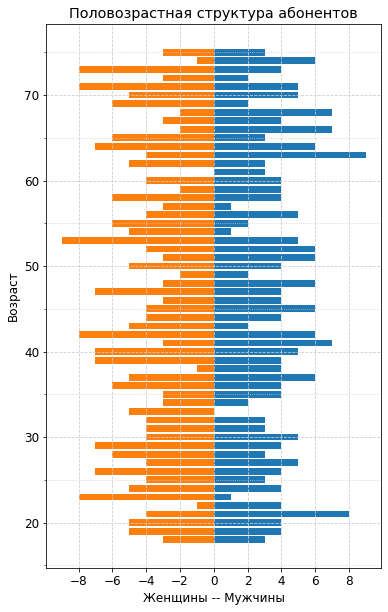

In [16]:
# построим половозрастную пирамиду
data = users_df.pivot_table(index='age',
                            columns='sex',
                            values='user_id',
                            aggfunc='count')

x = data.index
m = data.m
f = -data.f

fig, ax = plt.subplots(figsize=(6, 10))

ax.barh(x, m, align='center')
ax.barh(x, f, align='center')

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

ax.set_xlabel('Женщины -- Мужчины')
ax.set_ylabel('Возраст')
ax.set_title('Половозрастная структура абонентов')

plt.show()

/Users/noga/opt/anaconda3/envs/praktikum_env_macos/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


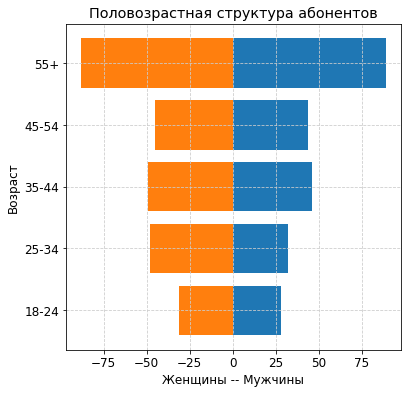

In [17]:
# что-то пирамида не похожа на пирамиду. укрупним возрастные группы

data = users_df.pivot_table(index=pd.cut(users_df.age, bins=[17, 24, 34, 44, 54, 99]),
                            columns='sex',
                            values='user_id',
                            aggfunc='count')

x = range(5)
m = data.m
f = -data.f

fig, ax = plt.subplots(figsize=(6, 6))

ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

ax.set_yticklabels(['', '18-24', '25-34', '35-44', '45-54', '55+'])
ax.set_xlabel('Женщины -- Мужчины')
ax.set_ylabel('Возраст')
ax.set_title('Половозрастная структура абонентов')

ax.barh(x, m)
ax.barh(x, f)
plt.show()

Нуу, в целом данные по возрастам выглядят скорее неправдоподобно – у нас примерно одинаковое число абонентов каждого возраста и пола. Обычно есть какой-то выраженный перекос. Спишем это на то, что это тренировочный сет. В реальной ситуации стоило бы выяснить, как так получилось.

In [18]:
# посмотрим на города
users_df.city.value_counts().head(20)

Москва              99
Санкт-Петербург     39
Новосибирск         16
Омск                14
Казань              14
Уфа                 12
Краснодар           11
Набережные Челны    11
Ульяновск           11
Екатеринбург        11
Челябинск            9
Самара               9
Нижний Новгород      8
Волгоград            8
Пермь                8
Улан-Удэ             7
Новокузнецк          7
Вологда              7
Красноярск           7
Сочи                 6
Name: city, dtype: int64

In [19]:
# посмотрим на даты
users_df.reg_date.describe(datetime_is_numeric=True)

count                              500
mean     2018-06-30 18:57:35.999999744
min                2018-01-01 00:00:00
25%                2018-04-07 12:00:00
50%                2018-07-02 12:00:00
75%                2018-09-29 00:00:00
max                2018-12-31 00:00:00
Name: reg_date, dtype: object

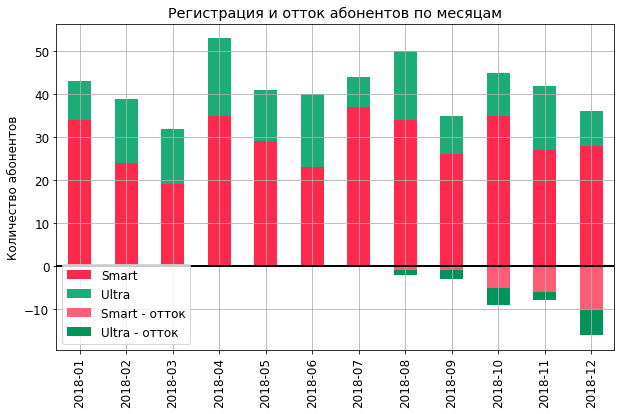

In [20]:
# построим график регистраций и оттока. ну и сразу распилим его на тарифы

reg = users_df.pivot_table(index=users_df.reg_date.dt.to_period('m'),
                     columns='tariff',
                     values='user_id',
                     aggfunc='count')

churn = users_df.pivot_table(index=users_df.churn_date.dt.to_period('m'),
                     columns='tariff',
                     values='user_id',
                     aggfunc=lambda x: x.count()*-1)

data = reg.merge(churn, how='left', left_index=True, right_index=True)

fig, ax = plt.subplots()
data.plot(kind='bar',
          stacked=True,
          ax=ax,
          color=('#ff294d', '#1cac78', '#ff5c77', '#00945b'))
ax.grid()
zero_line = ax.get_ygridlines()[2]
zero_line.set_color('black')
zero_line.set_linewidth(2)
ax.legend(labels=('Smart', 'Ultra', 'Smart - отток', 'Ultra - отток'), loc='lower left')
ax.set_title('Регистрация и отток абонентов по месяцам')
ax.set_xlabel('')
ax.set_ylabel('Количество абонентов')

plt.show()

Тут тоже что-то очень странное – у нас каждый месяц добавляеся примерно одинаковое количество новых абонентов. И совсем нет пользователей из прошлого.

Если предположить, что эти тарифы запустились только в январе 2018 года, то всё равно странно, что они так стабильны – по идее должен быть всплеск вскоре после запуска тарифа и постепенное убывание. Плюс какая-то сезонность. В общем, скорее непохоже на реальные данные. Но сделать ничего не можем – будем считать, что всё ок.

К тому же в нашей выборке есть пользователи, у которых история действий начинается в декабре - у них не будет даже одного целого месяца истории. К сожалению, придётся убрать из данных всех, у кого дата регистрации позднее 2 декабря – все метрики мы будем считать по месяцам – неполные периоды перекосят нам статистику.

In [21]:
# убьём всех моложе 1 декабря
users_df = users_df[users_df.reg_date < '2018.12.02']

Теперь надо рассчитать платёжные периоды для пользователей. Поскольку у пользователей разная дата начала тарифа, то и месячные периоды у каждого будут свои – в зависимости от даты начала договора. 

Чтобы не расчитывать период для каждой точки данных, мы рассчитаем их один раз для каждого дня начала договора и вынесем в словарик. Из него потом будем брать предпосчитанные периоды.  

In [22]:
# составим список уникальных дат
start_dates = users_df.reg_date.unique()

In [23]:
# составим словарь
pay_periods_dict = {}

def calculate_periods(start_date):
    period = 1
    break_date_list = [start_date]
    break_num_list = []

    while start_date + pd.DateOffset(months=period) <= pd.Timestamp('2019-01-01'):
            break_date = start_date + pd.DateOffset(months=period)
            break_date_list.append(break_date)
            break_num_list.append(period)
            period += 1

    pay_periods = pd.Series(break_num_list,
                            index=pd.IntervalIndex.from_breaks(break_date_list, closed='left')
                           )
    
    pay_periods_dict[start_date] = pay_periods

for date in start_dates:
    calculate_periods(pd.Timestamp(date))

In [24]:
# в ключах словаря – у нас даты начала договора.
# в значениях - вектора с интервальным индексом – для каждого интервала дат указан номер платёжного периода.
# например, у пользователей с датой начала договора 1 января 2018 будет 12 полных периодов
pay_periods_dict[pd.Timestamp('2018-01-01')]

[2018-01-01, 2018-02-01)     1
[2018-02-01, 2018-03-01)     2
[2018-03-01, 2018-04-01)     3
[2018-04-01, 2018-05-01)     4
[2018-05-01, 2018-06-01)     5
[2018-06-01, 2018-07-01)     6
[2018-07-01, 2018-08-01)     7
[2018-08-01, 2018-09-01)     8
[2018-09-01, 2018-10-01)     9
[2018-10-01, 2018-11-01)    10
[2018-11-01, 2018-12-01)    11
[2018-12-01, 2019-01-01)    12
dtype: int64

In [25]:
# чтобы узнать, в какой платежный период попадает действие, достаточно обратиться к индексу датой. 
# например, посмотрим, какой платежный период будет у пользователя 28 февраля,
# если он зарегистрировался 30 января 
# - уже второй (а не первый) – последний день февраля это первый день следующего периода
pay_periods_dict[pd.Timestamp('2018-01-30')][pd.Timestamp('2018-02-28')]

2

### Звонки

Проверим, что с данными всё ок. Посчитаем стоимость звонков.

In [26]:
calls_df = pd.read_csv(CALLS, parse_dates=[1])
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [27]:
print(f'Количество дубликатов – {calls_df.duplicated().sum()}')

Количество дубликатов – 0


In [28]:
# убедимся, что период времени совпадает с периодом юзеров. совпадает – 2018 год.
calls_df.call_date.describe(datetime_is_numeric=True)

count                           202607
mean     2018-09-02 20:01:37.583992832
min                2018-01-01 00:00:00
25%                2018-07-05 00:00:00
50%                2018-09-17 00:00:00
75%                2018-11-14 00:00:00
max                2018-12-31 00:00:00
Name: call_date, dtype: object

In [29]:
# проверим, что продолжительность звонков реалистичная. вполне: медиана - 6 минут. самый длинный - 38 минут.
calls_df.duration.describe()

count   202_607.00
mean          6.76
std           5.84
min           0.00
25%           1.30
50%           6.00
75%          10.70
max          38.00
Name: duration, dtype: float64

In [30]:
# округлим вверх дробные минуты согласно условиям тарификации
calls_df.duration = np.ceil(calls_df.duration).astype('int')

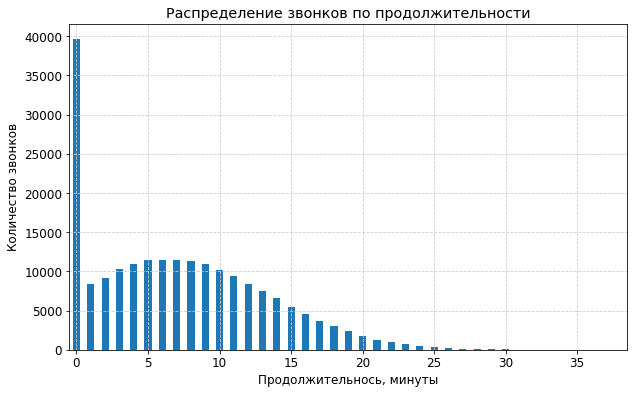

In [31]:
# и посмотрим на распределение по продолжительности
fig, ax = plt.subplots()
calls_df.duration.value_counts().sort_index().plot(kind='bar', ax=ax)


ax.yaxis.set_major_locator(MultipleLocator(5000))
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
plt.setp(ax.get_xticklabels(), rotation=0)

ax.set_xlabel('Продолжительнось, минуты')
ax.set_ylabel('Количество звонков')
ax.set_title('Распределение звонков по продолжительности')

plt.show()

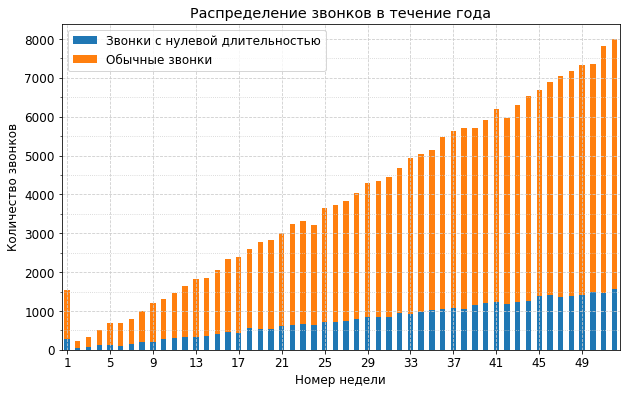

In [32]:
# и на распределение по неделям года. отдельно посчитаем нулевые звонки и обычные
fig, ax = plt.subplots()

(calls_df.pivot_table(index=calls_df['call_date'].dt.isocalendar().week,
                      columns=calls_df.duration > 0,
                      values='duration',
                      aggfunc='count')
 .plot(kind='bar', stacked=True, ax=ax)
)

ax.yaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
plt.setp(ax.get_xticklabels(), rotation=0)

ax.legend(['Звонки с нулевой длительностью', 'Обычные звонки'])
ax.set_xlabel('Номер недели')
ax.set_ylabel('Количество звонков')
ax.set_title('Распределение звонков в течение года')

plt.show()

Из-за того, что у нас количество абонентов монотонно прибывает в течение года, количество звонков так же монотонно растёт. Чтобы окончательно убедиться, что с данными всё ок, нормируем звонки и продолжительность на количество пользователей.

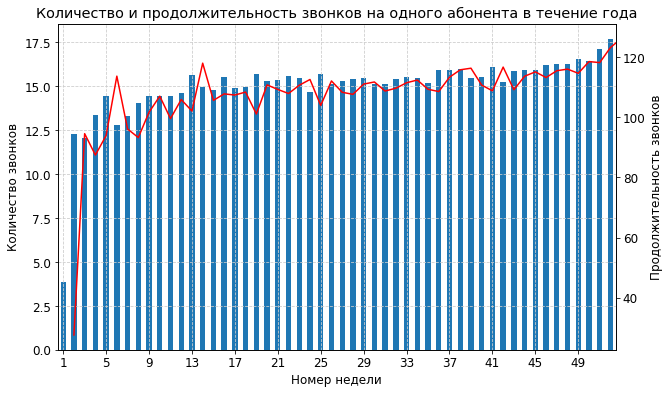

In [33]:
fig, ax = plt.subplots()

unique_users = calls_df.pivot_table(index=calls_df['call_date'].dt.isocalendar().week,
                      values='user_id',
                      aggfunc=lambda x: x.nunique())

calls_count = calls_df.pivot_table(index=calls_df['call_date'].dt.isocalendar().week,
                      values='id',
                      aggfunc="count")

calls_duration = calls_df.pivot_table(index=calls_df['call_date'].dt.isocalendar().week,
                      values='duration',
                      aggfunc="sum")

(calls_count.id / unique_users.user_id).plot(kind='bar', ax=ax)
ax2 = ax.twinx()
(calls_duration.duration / unique_users.user_id).plot(kind='line', ax=ax2, color='r')

ax.xaxis.set_major_locator(MultipleLocator(4))
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
plt.setp(ax.get_xticklabels(), rotation=0)


ax.set_xlabel('Номер недели')
ax.set_ylabel('Количество звонков')

ax2.set_ylabel('Продолжительность звонков')
ax.set_title('Количество и продолжительность звонков на одного абонента в течение года')

plt.show()

С данными, похоже, всё ок.

Теперь для каждого абонента посчитаем продолжительность по месяцам и рассчитаем стоимость звонков, но сначала выставим абонентам платежные периоды. Сумму минут и деньги будем считать уже по этим периодам.

In [34]:
# функцию для установки периодов будем использовать и для расчёта стоимости смс и интернета,
# поэтому в датасете переименуем колонки
calls_df = calls_df.rename({'call_date': 'date'}, axis=1)

In [35]:
# мы убрали декабрьских пользователей из данных о пользователях - уберём их и из звонков
calls_df = calls_df.query('user_id in @users_df.user_id')

In [36]:
# функция, которая будет выставлять платежный период по дате регистрации и дате действия 
def set_pay_period(row):
    reg = row.reg_date
    action = row.date
    if pay_periods_dict[reg].index.contains(action).any():
        return pay_periods_dict[reg][action]
    else:
        return np.nan

In [37]:
# запускать функцию на все данные слишком медленно. 
# так что сначала выделим все уникальные сочетания даты регистрации и даты звонка
# рассчитаем платежные периоды для этих сочетаний
# и смержим эти данные с данными о звонках
dates_periods = (calls_df
                     .merge(users_df[['user_id', 'reg_date']],
                            how='left',
                            on='user_id')
                     .groupby(['reg_date', 'date'])['duration']
                     .agg('count')
                     .reset_index()
                     .drop('duration', axis=1)
                    )

dates_periods['pay_period'] = dates_periods.apply(set_pay_period, axis=1)
dates_periods.head()

,reg_date,date,pay_period
0,2018-01-01,2018-01-01,1.00
1,2018-01-01,2018-01-02,1.00
2,2018-01-01,2018-01-03,1.00
3,2018-01-01,2018-01-04,1.00
4,2018-01-01,2018-01-05,1.00


In [38]:
# теперь добавим платежные периоды ко всем звонкам
calls_users = (calls_df.merge(users_df[['user_id', 'reg_date']],
                                         how='left',
                                         on='user_id'))
calls_df = calls_users.merge(dates_periods, on=['reg_date', 'date'], how='left')

Теперь можно завести новый датасет, куда будем складывать все данные по стоимости разных услуг.

Но сначала придётся забить один костыль (( - дело в том, что не все пользователи совершали звонки (отправляли смс, пользовались интернетом) – чтобы из-за таких пользователей не нарушились данные, придётся руками выставить им для соответствующих услуг нули. Это упражнение придётся проделывать и для смс, и для интернета.

Это весьма костыльное решение, но ничего лучше не придумал. К сожалению, в пандасе при мердже нельзя указать значение, которым бы заполнялись отсутствующие данные.

In [39]:
# найдем id пользователей, которые не совершали звонков
users_with_calls = set((calls_df
                        .pivot_table(index='user_id',
                                     columns='pay_period',
                                     values='duration',
                                     aggfunc=['sum'])['sum'])
                       .index)

all_users = set(users_df.user_id)
users_without_calls = list(all_users - users_with_calls)

users_without_calls

[1473, 1091, 1231, 1328, 1489, 1106]

In [40]:
# сделаем для них датасет c нулями
users_zeroes = pd.DataFrame(data=[[0 for _ in range(12)] for _ in range(len(users_without_calls))],
                          index=users_without_calls,
                          columns=[float(x) for x in range(1, 13)])
users_zeroes

,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00
1473,0,0,0,0,0,0,0,0,0,0,0,0
1091,0,0,0,0,0,0,0,0,0,0,0,0
1231,0,0,0,0,0,0,0,0,0,0,0,0
1328,0,0,0,0,0,0,0,0,0,0,0,0
1489,0,0,0,0,0,0,0,0,0,0,0,0
1106,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
# теперь можно, наконец, сделать новый сет, в котором будем собирать данные

# склеенные значения: пользователи со звонками и нулевые пользователи
concatenated_calls = pd.concat([(calls_df
                                 .pivot_table(index='user_id',
                                              columns='pay_period',
                                              values='duration',
                                              aggfunc=['sum'])
                                 ['sum']),
                                users_zeroes
                               ]
                              )
# добавим их в новый сет
user_fees = (concatenated_calls
             .merge(users_df[['user_id', 'tariff']],
                    how='outer',
                    left_index=True,
                    right_on='user_id')
            )

user_fees.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,user_id,tariff
0,299.00,284.00,403.00,482.00,368.00,341.00,340.00,NaN,NaN,NaN,NaN,NaN,1000,ultra
1,430.00,414.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1001,smart
2,220.00,262.00,227.00,191.00,219.00,300.00,NaN,NaN,NaN,NaN,NaN,NaN,1002,smart
3,938.00,851.00,806.00,922.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1003,ultra
4,92.00,154.00,141.00,151.00,102.00,176.00,58.00,NaN,NaN,NaN,NaN,NaN,1004,ultra


In [42]:
# для удобства 12 колонок с суммами минут по периодам схлопнем в одну
user_fees['calls_duration'] = user_fees.apply(lambda row: list(row.loc[1:12]), axis=1)
user_fees = user_fees[['user_id', 'tariff', 'calls_duration']]

user_fees.head()

,user_id,tariff,calls_duration
0,1000,ultra,"[299.0, 284.0, 403.0, 482.0, 368.0, 341.0, 340..."
1,1001,smart,"[430.0, 414.0, nan, nan, nan, nan, nan, nan, n..."
2,1002,smart,"[220.0, 262.0, 227.0, 191.0, 219.0, 300.0, nan..."
3,1003,ultra,"[938.0, 851.0, 806.0, 922.0, nan, nan, nan, na..."
4,1004,ultra,"[92.0, 154.0, 141.0, 151.0, 102.0, 176.0, 58.0..."


In [43]:
# напишем функцию для расчёта стоимости звонков и интернета.
# кроме строки датасета она принимает словарь с условиями тарифов
# и название услуги, для которой мы считаем деньги.
# колонки с количеством услуги в датасете должны называться
# 'calls_duration', 'sms_duration' или 'web_duration'

def calculate_fees(row, tariffs, service):
    service_row = service + '_duration'
    service_duration = row[service_row]
    limit = tariffs[row.tariff]['limits'][service]
    fee = tariffs[row.tariff]['fee'][service]
    payment_list = []
    
    for duration in service_duration:
        if np.isnan(duration):
            payment_list.append(np.nan)
        else:
            if duration <= limit:
                payment_list.append(0) 
            else:
                payment_list.append((duration - limit) * fee)
             
    return np.array(payment_list)

In [44]:
# добавим колонку со стоимостью звонков
user_fees['calls_fees'] = user_fees.apply(calculate_fees, args=[TARIFF, 'calls'], axis=1)

In [45]:
# посмотрим, что получилось
user_fees.head()

,user_id,tariff,calls_duration,calls_fees
0,1000,ultra,"[299.0, 284.0, 403.0, 482.0, 368.0, 341.0, 340...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ..."
1,1001,smart,"[430.0, 414.0, nan, nan, nan, nan, nan, nan, n...","[0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, ..."
2,1002,smart,"[220.0, 262.0, 227.0, 191.0, 219.0, 300.0, nan...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, nan, ..."
3,1003,ultra,"[938.0, 851.0, 806.0, 922.0, nan, nan, nan, na...","[0.0, 0.0, 0.0, 0.0, nan, nan, nan, nan, nan, ..."
4,1004,ultra,"[92.0, 154.0, 141.0, 151.0, 102.0, 176.0, 58.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ..."


### СМС

Проверим, что всё ок, и посчитаем стоимость.

In [46]:
sms_df = pd.read_csv(MESSAGES, parse_dates=[1])

In [47]:
sms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [48]:
print(f'Количество дубликатов – {sms_df.duplicated().sum()}')

Количество дубликатов – 0


In [49]:
# проверим диапазон дат
sms_df.message_date.describe(datetime_is_numeric=True)

count                           123036
mean     2018-09-04 15:28:42.227640576
min                2018-01-02 00:00:00
25%                2018-07-09 00:00:00
50%                2018-09-20 00:00:00
75%                2018-11-14 00:00:00
max                2018-12-31 00:00:00
Name: message_date, dtype: object

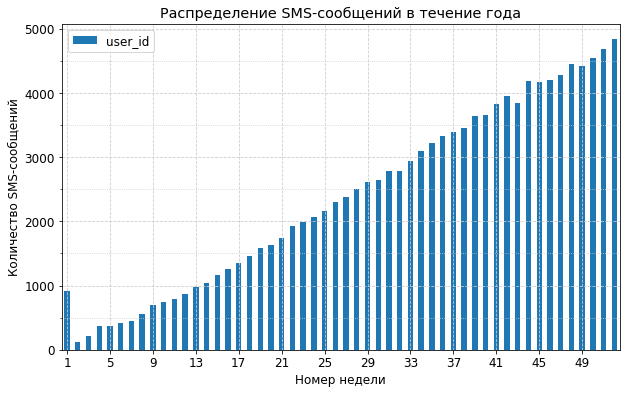

In [50]:
# построим диаграмму количества смсок по неделям
fig, ax = plt.subplots()

(sms_df.pivot_table(index=sms_df['message_date'].dt.isocalendar().week,
                      values='user_id',
                      aggfunc='count')
 .plot(kind='bar', ax=ax)
)

ax.yaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
plt.setp(ax.get_xticklabels(), rotation=0)

# ax.legend(['Звонки с нулевой длительностью', 'Обычные звонки'])
ax.set_xlabel('Номер недели')
ax.set_ylabel('Количество SMS-сообщений')
ax.set_title('Распределение SMS-сообщений в течение года')

plt.show()

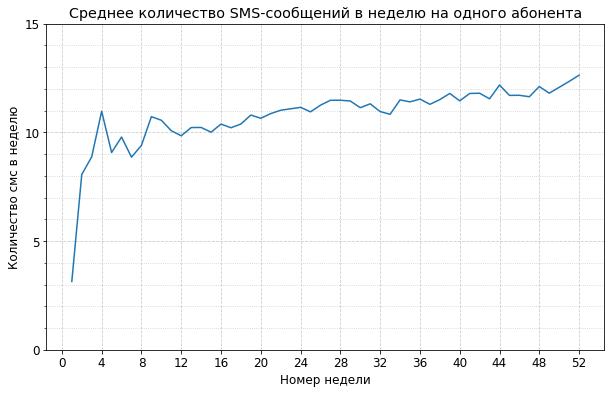

In [51]:
# из-за того, что количество абонентов у нас растёт с начала года, распределение странное. 
# нормируем на количество абонентов. 

fig, ax = plt.subplots()

unique_users = sms_df.pivot_table(index=sms_df['message_date'].dt.isocalendar().week,
                      values='user_id',
                      aggfunc=lambda x: x.nunique())

sms_count = sms_df.pivot_table(index=sms_df['message_date'].dt.isocalendar().week,
                      values='id',
                      aggfunc="count")

(sms_count.id / unique_users.user_id).plot(kind='line', ax=ax)

ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
plt.setp(ax.get_xticklabels(), rotation=0)

# ax.legend(['Звонки с нулевой длительностью', 'Обычные звонки'])
ax.set_ylim(0, 15)
ax.set_xlabel('Номер недели')
ax.set_ylabel('Количество смс в неделю')
ax.set_title('Среднее количество SMS-сообщений в неделю на одного абонента')

plt.show()

Ну, в целом с данными всё ок. Есть какая-то болтанка в начале года – там наверно мало данных. И почему-то незначительный рост среднего количества смс – вероятно, объясняется увеличением среднего стажа абонентов к концу года. Ну это всё мелочи.

Теперь посчитаем стоимость смс и добавим их в наш датасет.

In [52]:
# переименуем колонку с датами, чтобы наша функция сработала,
# и уберём декабрьских пользователей
sms_df = sms_df.rename({'message_date': 'date'}, axis=1)
sms_df = sms_df.query('user_id in @users_df.user_id')

In [53]:
# выделим уникальные сочетания регистрация-дата для смс.
# посчитаем платёжные периоды и выставим их смскам.
dates_periods = (sms_df
                     .merge(users_df[['user_id', 'reg_date']],
                            how='left',
                            on='user_id')
                     .groupby(['reg_date', 'date'])['id']
                     .agg('count')
                     .reset_index()
                     .drop('id', axis=1)
                    )

dates_periods['pay_period'] = dates_periods.apply(set_pay_period, axis=1)

sms_df = (sms_df
          .merge(users_df[['user_id', 'reg_date']],
                 how='left',
                 on='user_id')
          .merge(dates_periods,
                 on=['reg_date', 'date'],
                 how='left')
         )

sms_df.head()

,id,date,user_id,reg_date,pay_period
0,1000_0,2018-06-27,1000,2018-05-25,2.00
1,1000_1,2018-10-08,1000,2018-05-25,5.00
2,1000_2,2018-08-04,1000,2018-05-25,3.00
3,1000_3,2018-06-16,1000,2018-05-25,1.00
4,1000_4,2018-12-05,1000,2018-05-25,7.00


In [54]:
# найдем id пользователей, у которых не было смсок
users_with_sms = set((sms_df
                        .pivot_table(index='user_id',
                                     columns='pay_period',
                                     values='id',
                                     aggfunc=['count'])['count'])
                       .index)

all_users = set(users_df.user_id)
users_without_sms = list(all_users - users_with_sms)

users_without_sms

[1024,
 1152,
 1153,
 1157,
 1162,
 1290,
 1291,
 1292,
 1040,
 1428,
 1301,
 1429,
 1175,
 1049,
 1177,
 1179,
 1305,
 1053,
 1306,
 1435,
 1185,
 1442,
 1063,
 1322,
 1195,
 1456,
 1201,
 1204,
 1078,
 1334,
 1208,
 1462,
 1210,
 1339,
 1466,
 1085,
 1469,
 1220,
 1479,
 1224,
 1225,
 1228,
 1101,
 1360,
 1107,
 1363,
 1494,
 1367,
 1240,
 1114,
 1242,
 1116,
 1370,
 1118,
 1120,
 1248,
 1376,
 1254,
 1255,
 1001,
 1132,
 1260,
 1006,
 1388,
 1010,
 1143,
 1017]

In [55]:
# сделаем для них датасет c нулями
users_zeroes = pd.DataFrame(data=[[0 for _ in range(12)] for _ in range(len(users_without_sms))],
                          index=users_without_sms,
                          columns=[float(x) for x in range(1, 13)])
users_zeroes.head()

,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00
1024,0,0,0,0,0,0,0,0,0,0,0,0
1152,0,0,0,0,0,0,0,0,0,0,0,0
1153,0,0,0,0,0,0,0,0,0,0,0,0
1157,0,0,0,0,0,0,0,0,0,0,0,0
1162,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
# склеим нулевых и обычных пользователей,
# добавим всё в итоговый датасет
concatenated_sms = pd.concat([(sms_df.pivot_table(index='user_id',
                                              columns='pay_period',
                                              values='id',
                                              aggfunc='count')),
                                users_zeroes]
                              )

user_fees = concatenated_sms.merge(user_fees,
                                   left_index=True,
                                   right_on='user_id',
                                   how='outer')

# 12 колонок с суммами смс по периодам схлопнем в одну
user_fees['sms_duration'] = user_fees.apply(lambda row: list(row.loc[1:12]), axis=1)
user_fees = user_fees[['user_id', 'tariff', 'calls_duration', 'calls_fees', 'sms_duration']]

user_fees.head()

,user_id,tariff,calls_duration,calls_fees,sms_duration
0,1000,ultra,"[299.0, 284.0, 403.0, 482.0, 368.0, 341.0, 340...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ...","[63.0, 70.0, 81.0, 74.0, 56.0, 70.0, 69.0, nan..."
2,1002,smart,"[220.0, 262.0, 227.0, 191.0, 219.0, 300.0, nan...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, nan, ...","[8.0, 14.0, 8.0, 6.0, 13.0, 17.0, nan, nan, na..."
3,1003,ultra,"[938.0, 851.0, 806.0, 922.0, nan, nan, nan, na...","[0.0, 0.0, 0.0, 0.0, nan, nan, nan, nan, nan, ...","[81.0, 95.0, 85.0, 82.0, nan, nan, nan, nan, n..."
4,1004,ultra,"[92.0, 154.0, 141.0, 151.0, 102.0, 176.0, 58.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ...","[154.0, 155.0, 163.0, 160.0, 141.0, 165.0, 170..."
5,1005,smart,"[519.0, 477.0, 763.0, 538.0, 635.0, 584.0, 608...","[57.0, 0.0, 789.0, 114.0, 405.0, 252.0, 324.0,...","[40.0, 48.0, 48.0, 42.0, 42.0, 53.0, 55.0, 62...."


In [57]:
# посчитаем стоимость смс
user_fees['sms_fees'] = user_fees.apply(calculate_fees, args=[TARIFF, 'sms'], axis=1)

In [58]:
# проверим, что всё успешно
user_fees.head()

,user_id,tariff,calls_duration,calls_fees,sms_duration,sms_fees
0,1000,ultra,"[299.0, 284.0, 403.0, 482.0, 368.0, 341.0, 340...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ...","[63.0, 70.0, 81.0, 74.0, 56.0, 70.0, 69.0, nan...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ..."
2,1002,smart,"[220.0, 262.0, 227.0, 191.0, 219.0, 300.0, nan...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, nan, ...","[8.0, 14.0, 8.0, 6.0, 13.0, 17.0, nan, nan, na...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, nan, ..."
3,1003,ultra,"[938.0, 851.0, 806.0, 922.0, nan, nan, nan, na...","[0.0, 0.0, 0.0, 0.0, nan, nan, nan, nan, nan, ...","[81.0, 95.0, 85.0, 82.0, nan, nan, nan, nan, n...","[0.0, 0.0, 0.0, 0.0, nan, nan, nan, nan, nan, ..."
4,1004,ultra,"[92.0, 154.0, 141.0, 151.0, 102.0, 176.0, 58.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ...","[154.0, 155.0, 163.0, 160.0, 141.0, 165.0, 170...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ..."
5,1005,smart,"[519.0, 477.0, 763.0, 538.0, 635.0, 584.0, 608...","[57.0, 0.0, 789.0, 114.0, 405.0, 252.0, 324.0,...","[40.0, 48.0, 48.0, 42.0, 42.0, 53.0, 55.0, 62....","[0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 15.0, 36.0, 3.0..."


### Интернет

Проверим данные и рассчитаем стоимость.

In [59]:
web_df = pd.read_csv(INTERNET, parse_dates=[2], usecols=[1, 2, 3, 4])

In [60]:
web_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


In [61]:
print(f'Количество дубликатов – {web_df.duplicated().sum()}')

Количество дубликатов – 0


In [62]:
# проверим диапазон дат
web_df.session_date.describe(datetime_is_numeric=True)

count                           149396
mean     2018-09-02 12:55:35.221826560
min                2018-01-01 00:00:00
25%                2018-07-05 00:00:00
50%                2018-09-17 00:00:00
75%                2018-11-14 00:00:00
max                2018-12-31 00:00:00
Name: session_date, dtype: object

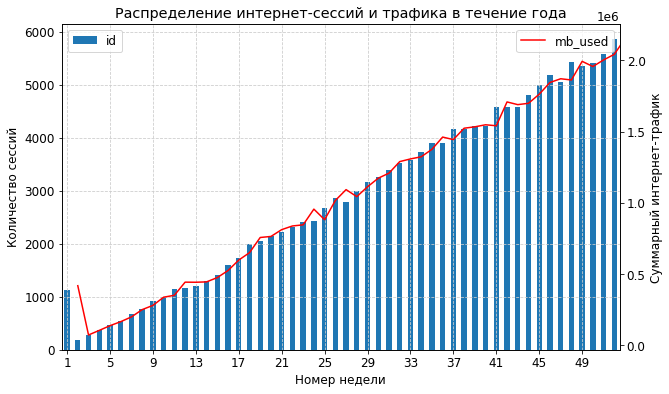

In [63]:
# посмотрим на график
fig, ax = plt.subplots()

sessions_sum = web_df.pivot_table(index=web_df['session_date'].dt.isocalendar().week,
                      values='mb_used',
                      aggfunc="sum")

sessions_count = web_df.pivot_table(index=web_df['session_date'].dt.isocalendar().week,
                      values='id',
                      aggfunc="count")

sessions_count.plot(kind='bar', ax=ax)
ax2 = ax.twinx()
sessions_sum.plot(kind='line', ax=ax2, color='r')

ax.xaxis.set_major_locator(MultipleLocator(4))
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
plt.setp(ax.get_xticklabels(), rotation=0)


ax.set_xlabel('Номер недели')
ax.set_ylabel('Количество сессий')

ax2.set_ylabel('Суммарный интернет-трафик')
ax.set_title('Распределение интернет-сессий и трафика в течение года')

plt.show()

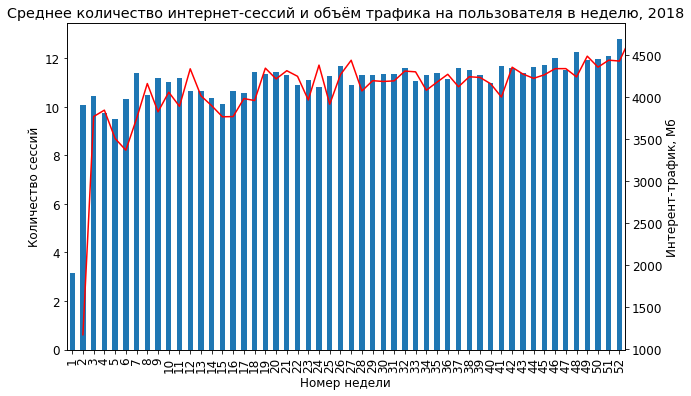

In [64]:
# и то же самое – нормированно на пользователей
fig, ax = plt.subplots()

sessions_sum = web_df.pivot_table(index=web_df['session_date'].dt.isocalendar().week,
                      values='mb_used',
                      aggfunc="sum")

sessions_count = web_df.pivot_table(index=web_df['session_date'].dt.isocalendar().week,
                      values='id',
                      aggfunc="count")

unique_users = web_df.pivot_table(index=web_df['session_date'].dt.isocalendar().week,
                      values='user_id',
                      aggfunc=lambda x: x.nunique())

(sessions_count.id / unique_users.user_id).plot(kind='bar', ax=ax)
ax2 = ax.twinx()
(sessions_sum.mb_used / unique_users.user_id).plot(kind='line', ax=ax2, color='r')

# ax.yaxis.set_major_locator(MultipleLocator(1000))
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# ax.xaxis.set_major_locator(MultipleLocator(4))
# ax.grid(which='major', color='#CCCCCC', linestyle='--')
# ax.grid(which='minor', color='#CCCCCC', linestyle=':')
# plt.setp(ax.get_xticklabels(), rotation=0)


ax.set_xlabel('Номер недели')
ax.set_ylabel('Количество сессий')

ax2.set_ylabel('Интерент-трафик, Мб')
ax.set_title('Среднее количество интернет-сессий и объём трафика на пользователя в неделю, 2018')

plt.show()

Всё ок. Выставим платёжные периоды. Превратим мегабайты в гигабайты с округлением. И посчитаем стоимость.

In [65]:
# переименуем колонку с датами, чтобы наша функция сработала,
# уберём декабрьских пользователей
# 
web_df = web_df.rename({'session_date': 'date'}, axis=1)
web_df = web_df.query('user_id in @users_df.user_id')

In [66]:
# выделим уникальные сочетания регистрация-дата для интернет-сессий.
# посчитаем платёжные периоды и выставим их сессиям.
dates_periods = (web_df
                     .merge(users_df[['user_id', 'reg_date']],
                            how='left',
                            on='user_id')
                     .groupby(['reg_date', 'date'])['id']
                     .agg('count')
                     .reset_index()
                     .drop('id', axis=1)
                    )

dates_periods['pay_period'] = dates_periods.apply(set_pay_period, axis=1)

web_df = (web_df
          .merge(users_df[['user_id', 'reg_date']],
                 how='left',
                 on='user_id')
          .merge(dates_periods,
                 on=['reg_date', 'date'],
                 how='left')
         )

web_df.head()

,id,mb_used,date,user_id,reg_date,pay_period
0,1000_0,112.95,2018-11-25,1000,2018-05-25,7.00
1,1000_1,1_052.81,2018-09-07,1000,2018-05-25,4.00
2,1000_2,1_197.26,2018-06-25,1000,2018-05-25,2.00
3,1000_3,550.27,2018-08-22,1000,2018-05-25,3.00
4,1000_4,302.56,2018-09-24,1000,2018-05-25,4.00


In [67]:
# найдем id пользователей, у которых не было веб-сессий
users_with_web = set((web_df
                        .pivot_table(index='user_id',
                                     columns='pay_period',
                                     values='id',
                                     aggfunc=['count'])['count'])
                       .index)

all_users = set(users_df.user_id)
users_without_web = list(all_users - users_with_web)

users_without_web

[1273]

In [68]:
# сделаем для этого несчастного датасет c нулями
users_zeroes = pd.DataFrame(data=[[0 for _ in range(12)] for _ in range(len(users_without_web))],
                          index=users_without_web,
                          columns=[float(x) for x in range(1, 13)])

users_zeroes.head()

,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00
1273,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
# посчитаем объём трафика по периодам, округлим вверх
# добавим нулевого пользователя
# и запишем всё в итоговый датасет

concatenated_web = pd.concat([web_df.pivot_table(index='user_id',
                                                 columns='pay_period',
                                                 values='mb_used',
                                                 aggfunc=lambda x: np.ceil((np.sum(x) / 1024))),
                                users_zeroes]
                              )

user_fees = concatenated_web.merge(user_fees,
                                   left_index=True,
                                   right_on='user_id',
                                   how='outer')

# 12 колонок с суммами трафика по периодам схлопнем в одну
user_fees['web_duration'] = user_fees.apply(lambda row: list(row.loc[1:12]), axis=1)
user_fees = user_fees[['user_id', 'tariff',
                       'calls_duration', 'calls_fees',
                       'sms_duration', 'sms_fees',
                       'web_duration']]

user_fees.head()

,user_id,tariff,calls_duration,calls_fees,sms_duration,sms_fees,web_duration
0,1000,ultra,"[299.0, 284.0, 403.0, 482.0, 368.0, 341.0, 340...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ...","[63.0, 70.0, 81.0, 74.0, 56.0, 70.0, 69.0, nan...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ...","[18.0, 19.0, 12.0, 17.0, 16.0, 16.0, 9.0, nan,..."
1,1001,smart,"[430.0, 414.0, nan, nan, nan, nan, nan, nan, n...","[0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[18.0, 14.0, nan, nan, nan, nan, nan, nan, nan..."
2,1002,smart,"[220.0, 262.0, 227.0, 191.0, 219.0, 300.0, nan...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, nan, ...","[8.0, 14.0, 8.0, 6.0, 13.0, 17.0, nan, nan, na...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, nan, ...","[19.0, 17.0, 21.0, 13.0, 18.0, 18.0, nan, nan,..."
3,1003,ultra,"[938.0, 851.0, 806.0, 922.0, nan, nan, nan, na...","[0.0, 0.0, 0.0, 0.0, nan, nan, nan, nan, nan, ...","[81.0, 95.0, 85.0, 82.0, nan, nan, nan, nan, n...","[0.0, 0.0, 0.0, 0.0, nan, nan, nan, nan, nan, ...","[12.0, 17.0, 16.0, 7.0, nan, nan, nan, nan, na..."
4,1004,ultra,"[92.0, 154.0, 141.0, 151.0, 102.0, 176.0, 58.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ...","[154.0, 155.0, 163.0, 160.0, 141.0, 165.0, 170...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ...","[21.0, 20.0, 25.0, 22.0, 19.0, 15.0, 16.0, nan..."


In [70]:
# добавим колонку со стоимостью интернета
user_fees['web_fees'] = user_fees.apply(calculate_fees, args=[TARIFF, 'web'], axis=1)
user_fees.head()

,user_id,tariff,calls_duration,calls_fees,sms_duration,sms_fees,web_duration,web_fees
0,1000,ultra,"[299.0, 284.0, 403.0, 482.0, 368.0, 341.0, 340...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ...","[63.0, 70.0, 81.0, 74.0, 56.0, 70.0, 69.0, nan...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ...","[18.0, 19.0, 12.0, 17.0, 16.0, 16.0, 9.0, nan,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ..."
1,1001,smart,"[430.0, 414.0, nan, nan, nan, nan, nan, nan, n...","[0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[18.0, 14.0, nan, nan, nan, nan, nan, nan, nan...","[600.0, 0.0, nan, nan, nan, nan, nan, nan, nan..."
2,1002,smart,"[220.0, 262.0, 227.0, 191.0, 219.0, 300.0, nan...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, nan, ...","[8.0, 14.0, 8.0, 6.0, 13.0, 17.0, nan, nan, na...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, nan, ...","[19.0, 17.0, 21.0, 13.0, 18.0, 18.0, nan, nan,...","[800.0, 400.0, 1200.0, 0.0, 600.0, 600.0, nan,..."
3,1003,ultra,"[938.0, 851.0, 806.0, 922.0, nan, nan, nan, na...","[0.0, 0.0, 0.0, 0.0, nan, nan, nan, nan, nan, ...","[81.0, 95.0, 85.0, 82.0, nan, nan, nan, nan, n...","[0.0, 0.0, 0.0, 0.0, nan, nan, nan, nan, nan, ...","[12.0, 17.0, 16.0, 7.0, nan, nan, nan, nan, na...","[0.0, 0.0, 0.0, 0.0, nan, nan, nan, nan, nan, ..."
4,1004,ultra,"[92.0, 154.0, 141.0, 151.0, 102.0, 176.0, 58.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ...","[154.0, 155.0, 163.0, 160.0, 141.0, 165.0, 170...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ...","[21.0, 20.0, 25.0, 22.0, 19.0, 15.0, 16.0, nan...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ..."


### Сводные показатели

Исходные данные готовы – теперь можно добавить несколько сводных показателей.

In [71]:
# посчитаем для каждого пользователя и платежного периода общую сумму доплаты
user_fees['total_extra_fees'] = user_fees.calls_fees + user_fees.sms_fees + user_fees.web_fees

In [72]:
# посчитаем среднюю сумму, которую пользователи платили по месяцам с учётом фиксированной абонентской платы
def calc_mean_total_fee(row):
    total_extra_fees = row.total_extra_fees
    tariff_price = TARIFF[row.tariff]['price']
    mean_fee = np.nanmean([extra_fee + tariff_price for extra_fee in total_extra_fees])
    return mean_fee
                
user_fees['mean_total_fee'] = user_fees.apply(calc_mean_total_fee ,axis=1)

In [73]:
# посчитаем среднемесячную сумму доплаты
user_fees['mean_extra_fee'] = user_fees.apply(lambda row: np.nanmean(row.total_extra_fees),axis=1)

In [74]:
# посчитаем средние объёмы потребления для разных видов услуг
user_fees['mean_calls'] = user_fees.apply(lambda row: np.nanmean(row.calls_duration),axis=1)
user_fees['mean_sms'] = user_fees.apply(lambda row: np.nanmean(row.sms_duration),axis=1)
user_fees['mean_web'] = user_fees.apply(lambda row: np.nanmean(row.web_duration),axis=1)

In [75]:
# добавим данные по пользователям: город, пол, возраст, количество периодов, что пользователь с нами
user_fees = user_fees.merge(users_df[['age', 'sex', 'city', 'churn_date', 'user_id']],
                            how='left',
                            on='user_id')

user_fees['periods_count'] = user_fees.total_extra_fees.apply(lambda x: sum(~np.isnan(x)))

In [76]:
# # и добавим галочку, с нами ещё пользователь или уже ушёл
# user_fees['is_active_user'] = user_fees.churn_date.apply(lambda x: x!=x)

## Анализ

Перейдём к анализу данных и ответу на поставленные вопросы.

### Потребление услуг

Посмотрим объём потребляемых услуг в среднем у абонентов с разными тарифами. И ради интереса посмотрим также на некоторые другие срезы.

In [77]:
# Посчитаем главные метрики
display(user_fees.pivot_table(columns='tariff', 
                      values=['mean_calls', 'mean_sms', 'mean_web'], 
                      aggfunc=['mean']).style.format('{:.0f}'))

user_fees.pivot_table(columns='tariff', 
                      values=['mean_calls', 'mean_sms', 'mean_web'], 
                      aggfunc=['median', 'std', 'var']).style.format('{:.0f}')



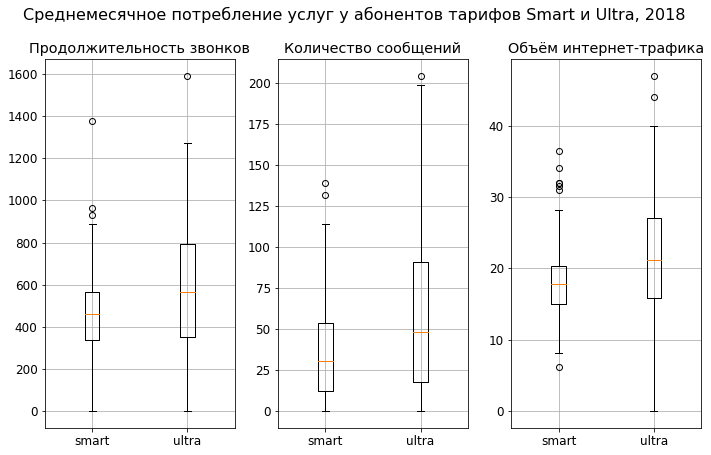

In [78]:
# и посмотрим на боксплоты по основным услугам
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

for param, ax, name in zip(['mean_calls', 'mean_sms', 'mean_web'],
                           [ax1, ax2, ax3],
                           ['Продолжительность звонков', 'Количество сообщений', 'Объём интернет-трафика']):
    param_grouped  = user_fees.groupby('tariff')[param]
    parameter = [col[1] for col in param_grouped]
    labels = [col[0] for col in param_grouped]
    ax.boxplot(parameter, labels=labels)
    ax.grid()
    ax.set_title(name)
fig.tight_layout()
plt.suptitle('Среднемесячное потребление услуг у абонентов тарифов Smart и Ultra, 2018', y=1.05, fontsize=16)
plt.show()

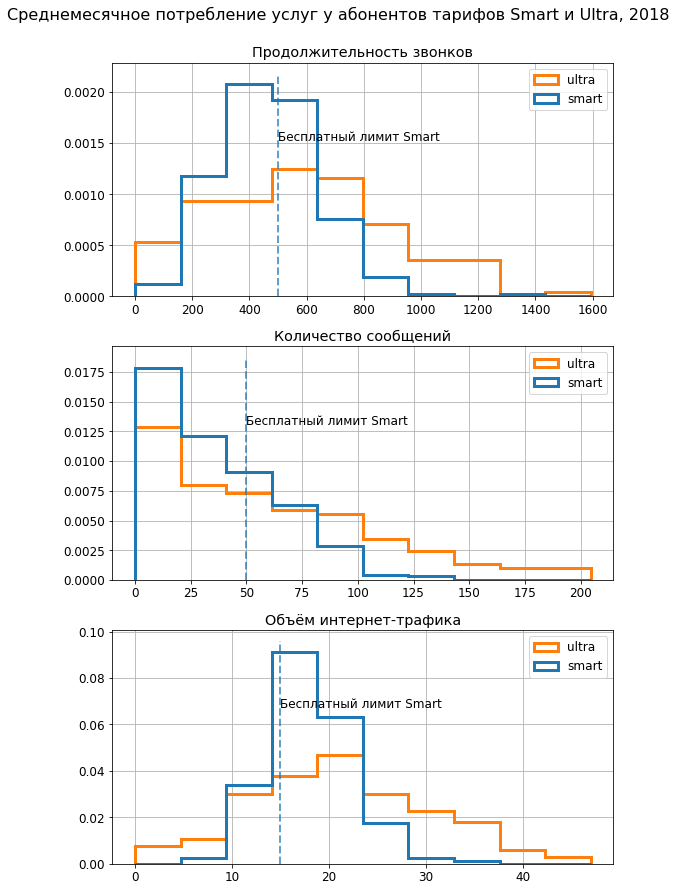

In [79]:
# и то же самое – нормированными гистограммами
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_figwidth(8)
fig.set_figheight(12)

for param, ax, name in zip(['mean_calls', 'mean_sms', 'mean_web'],
                           [ax1, ax2, ax3],
                           ['Продолжительность звонков', 'Количество сообщений', 'Объём интернет-трафика']):
    param_grouped  = user_fees.groupby('tariff')[param]
    parameter = [col[1] for col in param_grouped]
    labels = [col[0] for col in param_grouped]
    ax.hist(parameter,
            histtype='step',
            linewidth=3,
            density=True)
    
    x = TARIFF['smart']['limits'][(param.split('mean_')[1])]
    y = ax.get_ylim()[1]
    ax.vlines(x=x,
              ymin=0,
              ymax=y,
              linestyles='dashed',
              linewidth=2,
              alpha=0.7)
    ax.text(x, y*0.7, 'Бесплатный лимит Smart')
    
    ax.grid()
    ax.legend(['ultra', 'smart'])
    ax.set_title(name)
fig.tight_layout()
plt.suptitle('Среднемесячное потребление услуг у абонентов тарифов Smart и Ultra, 2018', fontsize=16, y=1.03)
plt.show()

In [80]:
# сделаем для абонентов разных тарифов именованные срезы
ultra_df = user_fees.query('tariff == "ultra"')
smart_df = user_fees.query('tariff == "smart"')

In [81]:
# посчитаем разницу средних по услугам
params = ['mean_calls', 'mean_sms', 'mean_web']

for param in params:
    diff = ultra_df[param].mean() / smart_df[param].mean() - 1
    print(f'Среднее по {param} у абонентов Ultra на {diff:.0%} больше, чем у абонентов Smart')

Среднее по mean_calls у абонентов Ultra на 24% больше, чем у абонентов Smart
Среднее по mean_sms у абонентов Ultra на 66% больше, чем у абонентов Smart
Среднее по mean_web у абонентов Ultra на 19% больше, чем у абонентов Smart


In [82]:
# рассчитаем p-value для нулевой гипотезы,
# что средние значения (потребление услуг) двух генеральных совокупностей (абоненты ultra и smart) не отличаются,
# а разницу в выборочных средних мы получили случайно

params = ['mean_calls', 'mean_sms', 'mean_web']

for param in params:
    pvalue = st.ttest_ind(ultra_df[param],
                          smart_df[param],
                          equal_var=False).pvalue
    
    print(f'P-value для параметра {param} равно {pvalue:.5f}')

P-value для параметра mean_calls равно 0.00013
P-value для параметра mean_sms равно 0.00000
P-value для параметра mean_web равно 0.00004


Очевидно, что **абоненты тарифа Ultra потребляют в среднем больше услуг связи, чем абоненты Smart**: у них на четверть больше продолжительность голосовой связи и на одну пятую – объём интернет-трафика.

Статистический тест подтверждает, что полученная разница выборочных средних неслучайна. Значения p-value для всех трёх параметров – меньше 0.001.

Распределения абонентов по объёму потребляемых услуг между тарифами различается. **Распределение у абонентов Smart – более плотное, у Ultra – более рассеянное**. Вероятно, это объясняется значением лимита услуг, включенных в абонентскую плату.

У Smart – лимиты по голосовой связи и интернету относительно невысокие – и значительная часть абонентов их превышает. Поскольку за превышение надо платить – абоненты стараются экономить. Поэтому распределение достаточно плотно группируется вокруг лимита.

У Ultra – лимиты выставлены с очень большим запасом – выбрать их почти невозможно. Поэтому абоненты потребляют столько, сколько им надо – и распределение получается более равномерным.

Посмотрим, есть ли разница в потреблении услуг по другим срезам – сравнивать будем абонентов в рамках одного и то же тарифа. 

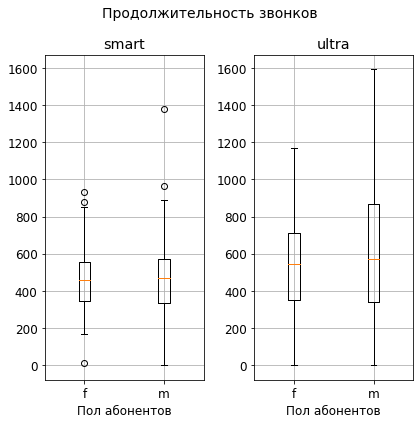

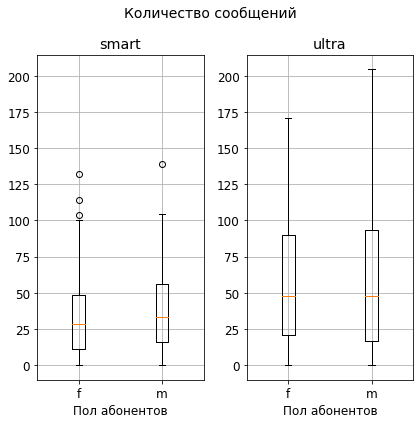

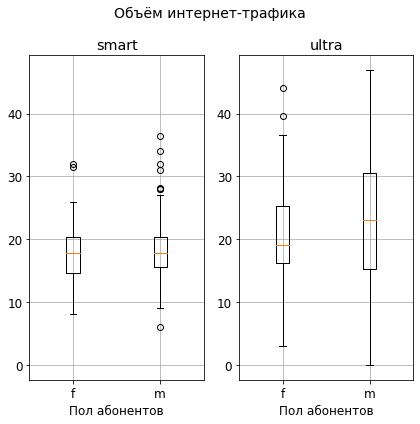

In [83]:
# боксплоты по тарифу и полу абонента
for param, name in zip(['mean_calls', 'mean_sms', 'mean_web'],
                       ['Продолжительность звонков', 'Количество сообщений', 'Объём интернет-трафика']):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(6)
    fig.set_figheight(6)

    for tariff, ax in zip(['smart', 'ultra'],
                               [ax1, ax2]):
        param_grouped  = user_fees[user_fees.tariff == tariff].groupby(['sex'])[param]
        parameter = [col[1] for col in param_grouped]
        labels = [col[0] for col in param_grouped]
        ax.boxplot(parameter, labels=labels)
        ax.set_xlabel('Пол абонентов')
        ax.grid()
        ax.set_title(tariff)

    ax1.sharey(ax2)
    plt.suptitle(name, fontsize=14)
    fig.tight_layout()
    plt.show()

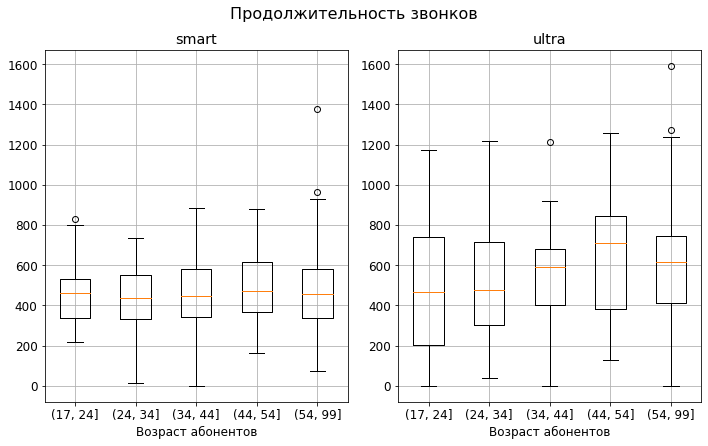

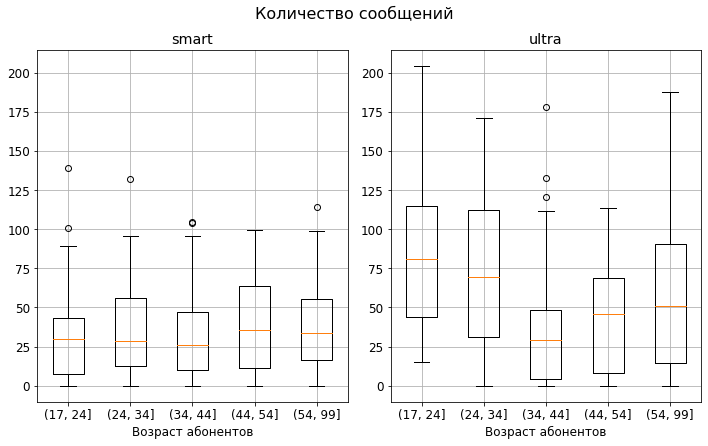

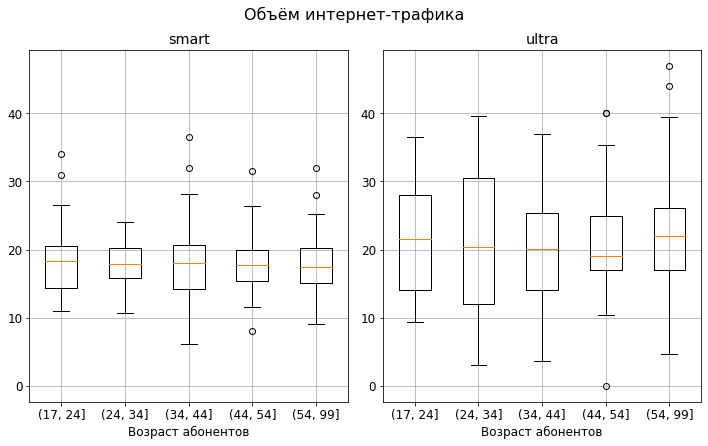

In [84]:
# боксплоты по возрастам
for param, name in zip(['mean_calls', 'mean_sms', 'mean_web'],
                       ['Продолжительность звонков', 'Количество сообщений', 'Объём интернет-трафика']):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.set_figheight(6)

    for tariff, ax in zip(['smart', 'ultra'],
                               [ax1, ax2]):
        tariff_sample = user_fees[user_fees.tariff == tariff]
        param_grouped  = tariff_sample.groupby(pd.cut(tariff_sample.age, bins=[17, 24, 34, 44, 54, 99]))[param]
        parameter = [col[1] for col in param_grouped]
        labels = [col[0] for col in param_grouped]
        ax.boxplot(parameter, labels=labels)
        ax.set_xlabel('Возраст абонентов')
        ax.grid()
        ax.set_title(tariff)

    ax1.sharey(ax2)
    fig.tight_layout()
    plt.suptitle(name, fontsize=16, y=1.03)
    plt.show()

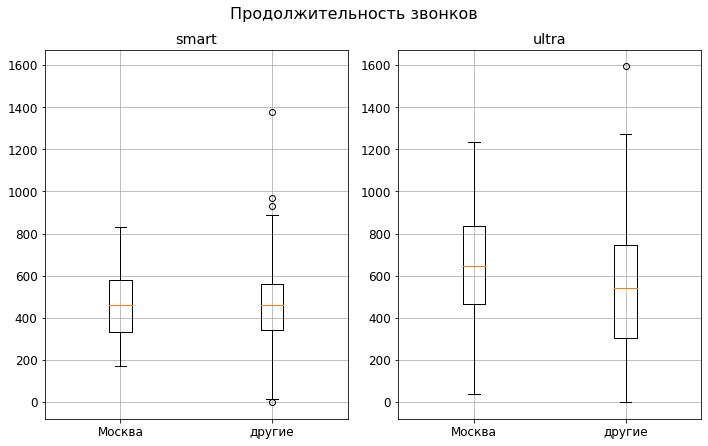

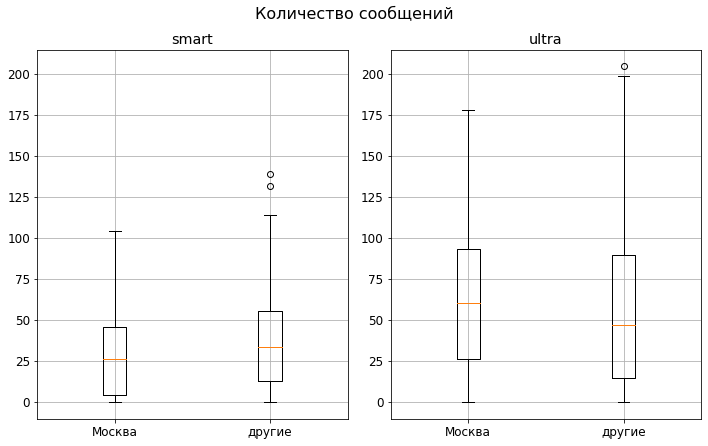

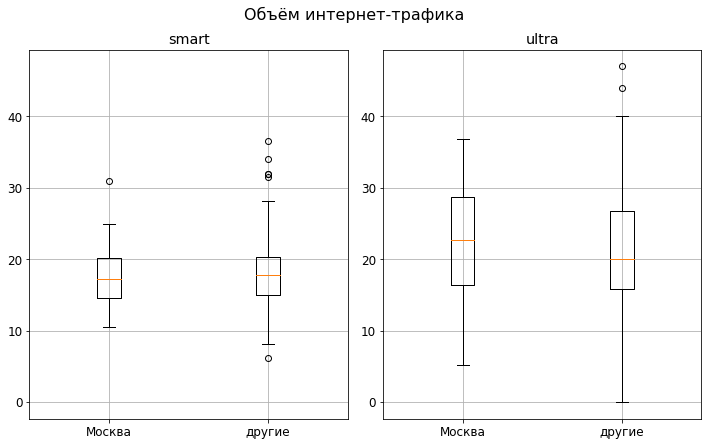

In [85]:
# боксплоты по городу

def city_type(row):
    if row.city != 'Москва':
        return 'другие'
    else:
        return 'Москва'

for param, name in zip(['mean_calls', 'mean_sms', 'mean_web'],
                       ['Продолжительность звонков', 'Количество сообщений', 'Объём интернет-трафика']):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    for tariff, ax in zip(['smart', 'ultra'],
                               [ax1, ax2]):
        tariff_sample = user_fees[user_fees.tariff == tariff]
        param_grouped  = tariff_sample.groupby(user_fees.apply(city_type, axis=1))[param]
        parameter = [col[1] for col in param_grouped]
        labels = [col[0] for col in param_grouped]
        ax.boxplot(parameter, labels=labels)
        ax.grid()
        ax.set_title(tariff)

    ax1.sharey(ax2)
    fig.tight_layout()
    plt.suptitle(name, fontsize=16, y=1.03)
    plt.show()

В общем, кажется, что **никакой особой разницы другие параметры абонентов не дают**. Разве что Москва на тарифе Ultra немного отличается от других городов. Но, как показывает статистический тест ниже, есть высокая вероятность, что наблюдаемые в выборках отличия на самом деле случайны.

In [86]:
# рассчитаем p-value для нулевой гипотезы,
# что средние значения (потребление услуг) двух генеральных совокупностей 
# (абоненты ultra из Москвы и других городов) не отличаются,
# а разницу в выборочных средних мы получили случайно

params = ['mean_calls', 'mean_sms', 'mean_web']

for param in params:
    pvalue = st.ttest_ind(ultra_df.query('city == "Москва"')[param],
                          ultra_df.query('city != "Москва"')[param],
                          equal_var=False).pvalue
    
    print(f'P-value для параметра {param} равно {pvalue:.5f}')

P-value для параметра mean_calls равно 0.23644
P-value для параметра mean_sms равно 0.48503
P-value для параметра mean_web равно 0.57285


### Платежи

Сравним, как различается выручка оператора от абонентов разных тарифов и в разных городах.

#### Разница между тарифами

In [87]:
# посчитаем основные статистики
user_fees.pivot_table(columns='tariff', 
                      values=['mean_extra_fee', 'mean_total_fee',], 
                      aggfunc=['mean', 'median', 'std', 'var']).style.format('{:_.0f}')

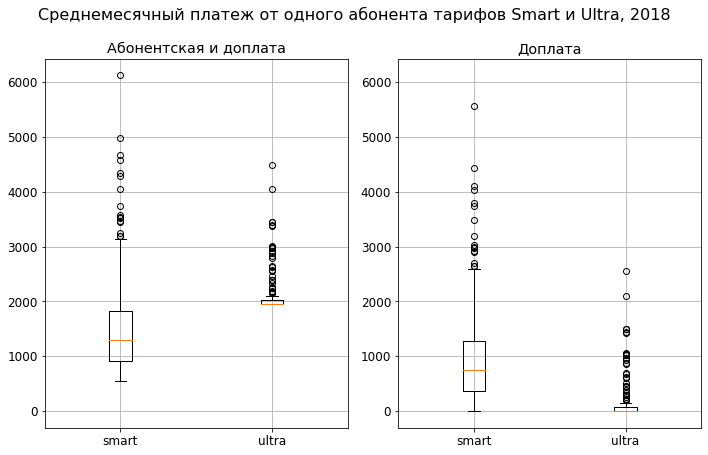

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2)

for param, ax, name in zip(['mean_total_fee', 'mean_extra_fee'],
                           [ax1, ax2],
                          ['Абонентская и доплата', 'Доплата']):
    param_grouped  = user_fees.groupby('tariff')[param]
    parameter = [col[1] for col in param_grouped]
    labels = [col[0] for col in param_grouped]
    ax.boxplot(parameter, labels=labels)
    ax.grid()
    ax.set_title(name)

ax1.set_ylim(0, 4000)
ax1.sharey(ax2)
fig.tight_layout()
plt.suptitle('Среднемесячный платеж от одного абонента тарифов Smart и Ultra, 2018', y=1.05, fontsize=16)
plt.show()

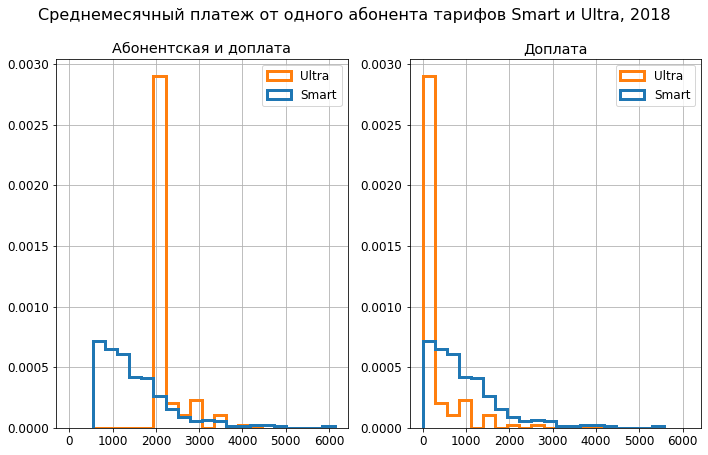

In [89]:
# и то же самое нормированными гистограммами
fig, (ax1, ax2) = plt.subplots(1, 2)

for param, ax, name in zip(['mean_total_fee', 'mean_extra_fee'],
                           [ax1, ax2],
                          ['Абонентская и доплата', 'Доплата']):
    param_grouped  = user_fees.groupby('tariff')[param]
    parameter = [col[1] for col in param_grouped]
    labels = [col[0] for col in param_grouped]
    ax.hist(parameter,
            histtype='step',
            linewidth=3,
            density=True, 
            bins=20)
    ax.grid()
    ax.set_title(name)
    ax.legend(['Ultra', 'Smart'])

ax1.sharey(ax2)
ax1.sharex(ax2)
fig.tight_layout()
plt.suptitle('Среднемесячный платеж от одного абонента тарифов Smart и Ultra, 2018', y=1.05, fontsize=16)
plt.show()

In [90]:
pvalue = st.ttest_ind(smart_df.mean_total_fee, ultra_df.mean_total_fee, equal_var=False).pvalue
print(f'''Значение p-value для нулевой гипотезы, что у двух 
генеральных совокупностей (абоненты Ultra и Smart) 
средние значения параметра (размер выручки) равны, составляет {pvalue:.5f}''')

Значение p-value для нулевой гипотезы, что у двух 
генеральных совокупностей (абоненты Ultra и Smart) 
средние значения параметра (размер выручки) равны, составляет 0.00000


Cредний месячный платеж (абонентская плата + доплата за превышение лимита) абонентов тарифа Ultra значительно выше, чем платеж абонентов Smart.

 Месячный платеж|Smart|Ultra|-
--- | :--- | :---|---
Среднее|1494|2140|+43%
Медиана|1301|1950|+50%

Статистический тест показывает, что вероятность получить такое отличие в выборке случайно, крайне низка.

#### Разница между Москвой и остальными городами

Теперь посмотрим, отличаются ли московские пользователи от остальных абонентов по размеру платежей.

In [91]:
# посчитаем средний размер платежей без разбивки по тарифам
cities = user_fees.groupby(user_fees.city=='Москва')['mean_total_fee'].agg(lambda x: round(np.mean(x)))
cities.index = ['Другие города', 'Москва']
cities = pd.DataFrame(cities)
cities['отклонение от среднего'] = cities.mean_total_fee / user_fees.mean_total_fee.mean() - 1
cities.style.format({'mean_total_fee': '{:_.0f}', 'отклонение от среднего': '{:_.1%}'})

,mean_total_fee,отклонение от среднего
Другие города,1_703,0.7%
Москва,1_640,-3.0%


In [92]:
# и для каждого тарифа в отдельности
print(f'''Средний размер платежей у пользователей из разных городов:
''')
for tariff in [smart_df, ultra_df]:
    cities = tariff.groupby(user_fees.city=='Москва')['mean_total_fee'].agg(lambda x: round(np.mean(x)))
    cities.index = ['Другие города', 'Москва']
    cities = pd.DataFrame(cities)
    cities['отклонение от среднего'] = cities.mean_total_fee / tariff.mean_total_fee.mean() - 1
    print(f'тариф {tariff["tariff"].iloc[0]}')
    display(cities.style.format({'mean_total_fee': '{:_.0f}', 'отклонение от среднего': '{:_.1%}'}))

Средний размер платежей у пользователей из разных городов:

тариф smart


,mean_total_fee,отклонение от среднего
Другие города,1_516,1.4%
Москва,1_404,-6.1%


тариф ultra


,mean_total_fee,отклонение от среднего
Другие города,2_155,0.7%
Москва,2_092,-2.3%


In [93]:
# проверим статистическую значимость отличий, найденных по выборкам

all_not_moscow = list(user_fees.groupby(user_fees.city=='Москва')['mean_total_fee'])[0][1]
all_moscow = list(user_fees.groupby(user_fees.city=='Москва')['mean_total_fee'])[1][1]
pvalue = st.ttest_ind(all_not_moscow, all_moscow, equal_var=True).pvalue
print(f'''Значение p-value для нулевой гипотезы, что у двух 
генеральных совокупностей (абоненты из Москвы и других городов) 
средние значения параметра (размер выручки) равны, составляет {pvalue:.2f}''')
print()
for tariff in [smart_df, ultra_df]:
    not_moscow = list(tariff.groupby(user_fees.city=='Москва')['mean_total_fee'])[0][1]
    moscow = list(tariff.groupby(user_fees.city=='Москва')['mean_total_fee'])[1][1]
    pvalue = st.ttest_ind(not_moscow, moscow, equal_var=True).pvalue
    print(f'''Значение p-value для нулевой гипотезы, что у двух 
генеральных совокупностей (абоненты тарифа {tariff["tariff"].iloc[0]} из Москвы и других городов) 
средние значения параметра (размер выручки) равны, составляет {pvalue:.2f}''')
    print()

Значение p-value для нулевой гипотезы, что у двух 
генеральных совокупностей (абоненты из Москвы и других городов) 
средние значения параметра (размер выручки) равны, составляет 0.50

Значение p-value для нулевой гипотезы, что у двух 
генеральных совокупностей (абоненты тарифа smart из Москвы и других городов) 
средние значения параметра (размер выручки) равны, составляет 0.35

Значение p-value для нулевой гипотезы, что у двух 
генеральных совокупностей (абоненты тарифа ultra из Москвы и других городов) 
средние значения параметра (размер выручки) равны, составляет 0.47



При расчёте по нашей выборке мы получили результат, что средний размер платежей у абонентов из Москвы ниже, чем у абонентов из других регионов (как в целом, так и в рамках одного тарифа). Однако это различие не проходит проверку статистическим тестом – при таком размере выборки очень высока вероятность того, что обнаруженные отличия – это случайность, и в генеральной совокупности таких отличий мы не увидим.

#### Структура дополнительных платежей  

Структура платежей абонентов тарифов Ultra и Smart заметно различается. **У пользователей Smart – в среднем дополнительные платежи превышают абонентскую плату**. В тарифе Ultra допплатежи составляют меньше 10% от всех поступлений.

Ради интереса изучим структуру платежей немного подробнее. Выясним, какую услугу надо продвигать, чтобы получить больше денег.

In [94]:
print('Доля дополнительных платежей у абонентов разных тарифов')
for tariff in [ultra_df, smart_df]:
    print(f'{tariff.tariff.iloc[0]}: {tariff.mean_extra_fee.mean() / tariff.mean_total_fee.mean():.0%}')


Доля дополнительных платежей у абонентов разных тарифов
ultra: 9%
smart: 63%


In [95]:
# посмотрим, как часто, за что и сколько абоненты разных тарифов платят дополнительно

# функция считает долю платежных периодов, когда у абонента были допплатежи, и среднюю сумму этих платежей
def count_extra_fee_periods(row):
    fee_period_count =  len([_ for _ in row['total_extra_fees'] if _ > 0])
    extra_share = fee_period_count / row['periods_count']
    mean_sms_fees = np.nanmean(row['sms_fees'])
    mean_web_fees = np.nanmean(row['web_fees'])
    mean_calls_fees = np.nanmean(row['calls_fees'])
    return pd.Series([extra_share, mean_sms_fees, mean_web_fees, mean_calls_fees])

# разделим абонентов на группы по тому, как часто они платили дополнительно. 
# для каждой группы посмотрим за что и сколько платили
for tariff in [ultra_df, smart_df]:
    df = tariff.apply(count_extra_fee_periods, axis=1).rename({0: 'extra_share',
                                                               1: 'mean_sms_fees',
                                                               2: 'mean_web_fees',
                                                               3: 'mean_calls_fees'}, axis=1)
    df = (df.groupby(pd.cut(df['extra_share'],
                            bins=[-0.000001, 0.000001, 0.25, 0.5, 0.75, 0.99, 1],
                            labels=['0', '1-25%', '26-50%', '51-75%', '76-99%', '100%']))
          .agg({'extra_share': 'count',
                'mean_sms_fees': 'mean',
                'mean_web_fees': 'mean',
                'mean_calls_fees': 'mean'})
          .rename({'extra_share': 'user_count'}, axis=1)
         )

    df.insert(1,'user_share', df.user_count / df.user_count.sum())
    print(tariff.tariff.iloc[0])
    display(df.style.format({'user_share': '{:.0%}',
                             'mean_sms_fees': '{:_.0f}',
                             'mean_web_fees': '{:_.0f}',
                             'mean_calls_fees': '{:_.0f}'}))
    print('-----------------------')
    print()


ultra


,user_count,user_share,mean_sms_fees,mean_web_fees,mean_calls_fees
extra_share,,,,,
0,99,70%,0,0,0
1-25%,8,6%,0,96,0
26-50%,11,8%,0,245,0
51-75%,6,4%,0,497,0
76-99%,6,4%,0,923,0
100%,11,8%,0,1_352,0


-----------------------

smart


,user_count,user_share,mean_sms_fees,mean_web_fees,mean_calls_fees
extra_share,,,,,
0,10,3%,0,0,0
1-25%,11,3%,0,99,5
26-50%,25,8%,0,208,32
51-75%,36,11%,5,414,43
76-99%,41,13%,5,599,62
100%,201,62%,31,979,259


-----------------------



In [96]:
smart_df.web_fees.apply(np.nanmean).median()

600.0

Тариф **Ultra**

- 70% абонентов за всю свою историю (у нас абоненты со стажем от 1 до 12 месяцев примерно поровну) ни разу не платили за превышение лимитов.
- 8% самых хардкорных абонентов платили дополнительно в каждый месяц своей истории.
- Единственная услуга, за которую платили, – это дополнительный веб-трафик.
- Для 8% хардкорных абонентов эта допплата составляла в среднем более 1350 рублей.

Тариф **Smart**

- 62% абонентов оплачивали превышение лимитов каждый месяц без исключения.
- Абоненты этой группы платили в среднем 980 рублей за интернет, 260 рублей за звонки и 30 рублей за сообщения.
- Вообще не платили дополнительно только 3% пользователей тарифа.

Итого, мы подтвердили вполне очевидное – сейчас допплатежи актуальны только для тарифа Smart, а самая востребованная услуга, за которую абоненты доплачивают больше всего денег – это доступ в интернет.

### Прибыль

Абоненты более дорого тарифа Ultra платят в среднем больше денег, чем абоненты бюджетного тарифа Smart – даже несмотря на большой объём дополнительных платежей за превышение лимитов у абонентов Smart. Это не удивительно.

Однако услуг абоненты Ultra потребляют также больше, чем абоненты Smart. Значит и затраты компании на обслуживание Ultra выше, чем на Smart. Следовательно одного лишь показателя платежей недостаточно для определения группы клиентов более выгодной в плане прибыли.

Мы не знаем, как формируется себестоимость оказания услуг абонентам. Но можем ради интереса прикинуть простенькую экономическую модель на основе показателей "с потолка".

Будем считать, что затраты на одного абонента складываются из:
- фиксированной части, не зависящей от объёма потребления – пусть она будет равна 100₽ в месяц.
- переменной части, которая зависит от объёма оказанных услуг. Пусть она будет равна 1/10 части от ставок за превышение на тарифе Ultra:
    - 1 смс - 0,1₽
    - 1 минута связи - 0,1₽
    - 1 Гб трафика - 15₽

Исходя из этих условных цифр рассчитаем среднюю прибыль от одного абонента на разных тарифах.

In [97]:
# словарик со ставками себестоимости разных услуг
COSTS = {'web': 15, 'calls': 0.1, 'sms': 0.1, 'const': 500}
# COSTS = {'web': 5, 'calls': 0.1, 'sms': 0.01, 'const': 100}

# функция для расчёта затрат на абонента
def calc_costs(row):
    service_costs = np.array([0.0 for _ in range(12)])
    for service in ['web', 'calls', 'sms']:
        service_fees = np.array([month * COSTS[service] for month in row[service+'_duration']])
        service_costs += service_fees
    service_costs += COSTS['const']
    return np.nanmean(service_costs)

# добавим в сет колонку с затратами
user_fees['mean_service_cost'] = user_fees.apply(calc_costs, axis=1)

In [98]:
# посчитаем среднюю прибыль
revenue = user_fees.groupby('tariff')['mean_total_fee'].mean()
cost = user_fees.groupby('tariff')['mean_service_cost'].mean()
pd.DataFrame(round(revenue - cost).astype('int')).rename({0: 'Средняя прибыль с одного абонента'}, axis=1)

,Средняя прибыль с одного абонента
tariff,
smart,675
ultra,1255


Ну что ж - если наши оценки затрат хоть немного верны, прибыль прямо пропорциональна выручке, и один абонент тарифа Ultra в среднем приносит компании почти вдвое больше денег, чем один абонент тарифа Smart. 

## Общий вывод

В целом исходные данные у нас нормального качества. Непонятно только, почему количество пользователей тарифа монотонно растёт, и в нашей выборке совсем нет пользователей из прошлого. Распределение абонентов по возрастам выглядит неправдоподобно.

Абоненты двух тарифов различаются между собой по объёму потребляемых услуг. У ползователей Ultra на четверть больше, чем на тарифе Smart, продолжительность голосовой связи и на одну пятую – объём интернет-трафика. Эта разница статистически значима.

Cредний месячный платеж (абонентская плата + доплата за превышение лимита) абонентов тарифа Ultra (2140₽) в 1,4 раза выше, чем платеж абонентов Smart (1494₽). Эта разница статистически значима.

Абоненты Ultra в среднем приносят больше денег, чем абоненты Smart, даже с учётом того, что они потребляют больше услуг.

Из-за разности условий тарифов структура платежей по ним различается. На тарифе Smart дополнительные платежи составляют более 60% от всех платежей от абонентов. 62% абонентов тарифа оплачивали превышение лимитов каждый месяц без исключения.

На тарифе Ultra дополнительные платежи составляют лишь 7% всей суммы платежей. 70% абонентов тарифа ни разу не платили за превышение лимитов.

Самая востребованная услуга, за которую абоненты доплачивают больше всего денег на обоих тарифах, – это доступ в интернет. В среднем абоненты Smart доплачивали за интернет около 750 рублей в месяц.

Размер выборки не позволяет достоверно определить отличаются ли пользователи из Москвы от остальных абонентов по объёму потребляемых услуг и платежам.